In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from matplotlib import rc
from numpy import inf

rc('text', usetex=True)

Welcome to JupyROOT 6.15/01


In [2]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [3]:
def getJetData(inputFiles):
    
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    scalar.append('quark_eta')
    scalar.append('quark_theta')
    scalar.append('quark_p')
    scalar.append('quark_pt')
    scalar.append('quark_id')
    cols.append('n_total')
    cols.append('n_charged')
    cols.append('jet_eta')
    cols.append('jet_theta')
    cols.append('jet_p')
    cols.append('jet_pt')
    cols.append('jet_qt')
    cols.append('jet_charge')

    cols.append('dphi_e_jet')
    cols.append('dR_q_jet')
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [4]:
def printSummary(df):
    print df['e_pt'].mean(), ' mean lepton pt'
    print df['y'].mean(), ' mean inelasticity'
    print df['jet_p'].mean(), ' mean jet p'
    print df['jet_pt'].mean(), ' mean jet pT'
    print df['jet_pt'].describe()
    print df['jet_charge'].mean(), 'mean charge'
    print df['x'].mean(), ' mean x'
    print df['Q2'].mean(), ' mean Q2'
    print df['Q2'].describe()
    return

In [5]:
def getData(inputFiles):
    
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    scalar.append('quark_eta')
    scalar.append('quark_theta')
    scalar.append('quark_p')
    scalar.append('quark_pt')
    
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [7]:
def applyCuts(df):
    temp = df
    temp = applyCut(temp, '0.1 < y < 0.85', '0.1 < y < 0.85')
    temp = applyCut(temp, 'Q2>100', 'Q2>100')
    #temp = applyCut(temp, 'x > 0.05', 'x>0.05')
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('logx= log(x)/2.3025850', inplace=True)
    return temp

In [8]:
def applyCutsJets(df):
    temp = df
    temp = applyCut(temp, '0.1 < y < 0.85', '0.1 < y < 0.85')
    temp = applyCut(temp, 'Q2>100', 'Q2>100')
    temp = applyCut(temp, 'jet_pt>5', 'jet_pt>5')
    #temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    #temp = applyCut(temp, 'Q2>100.0', ' Q2>100.0')
    
    temp.eval('dphi = 3.14159-dphi_e_jet', inplace=True)
    temp.eval('jet_qtnorm= jet_qt/sqrt(Q2)', inplace=True)
    temp.eval('jet_qtnormjetpt= jet_qt/sqrt(jet_pt)', inplace=True)
    temp.eval('jet_qtnormept= jet_qt/sqrt(e_pt)', inplace=True)

    df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get Data

In [9]:
#df = getData(['NC_10_275.root'])
df = getData(['NC-5-100.root'])

xsec = np.mean(df['xsec'])
xsec = xsec*1e9
print 'xsection %2.2f [pb]' %(xsec)
accepted = df.shape[0]
print 'accepted events' , accepted
to_cross_section = xsec/(1.0*accepted)

df = applyCuts(df)
print 'Accepted cross-section: %2.0f [pb]'%(df.shape[0]*to_cross_section)


Processed NC-5-100.root in 1.7 seconds
xsection 754.69 [pb]
accepted events 999999
0.1 < y < 0.85 895183  fraction kept: 89.5
Q2>100 892790  fraction kept: 99.7
Accepted cross-section: 674 [pb]


## Inclusive rate

In [10]:
##Total cross-section: 
## in units of fb:
lumi = 100 # in units of fb-1. 
integrated_rate    = 1000*lumi*xsec #multiply by 1000 and then 100 to get integrated yield for 100 fb-1
print 'Integrated rate %2.3f [M]' %(integrated_rate/1e6)
to_counts = to_cross_section*1000*lumi

Integrated rate 75.469 [M]


## Plot all variables in the electron beam

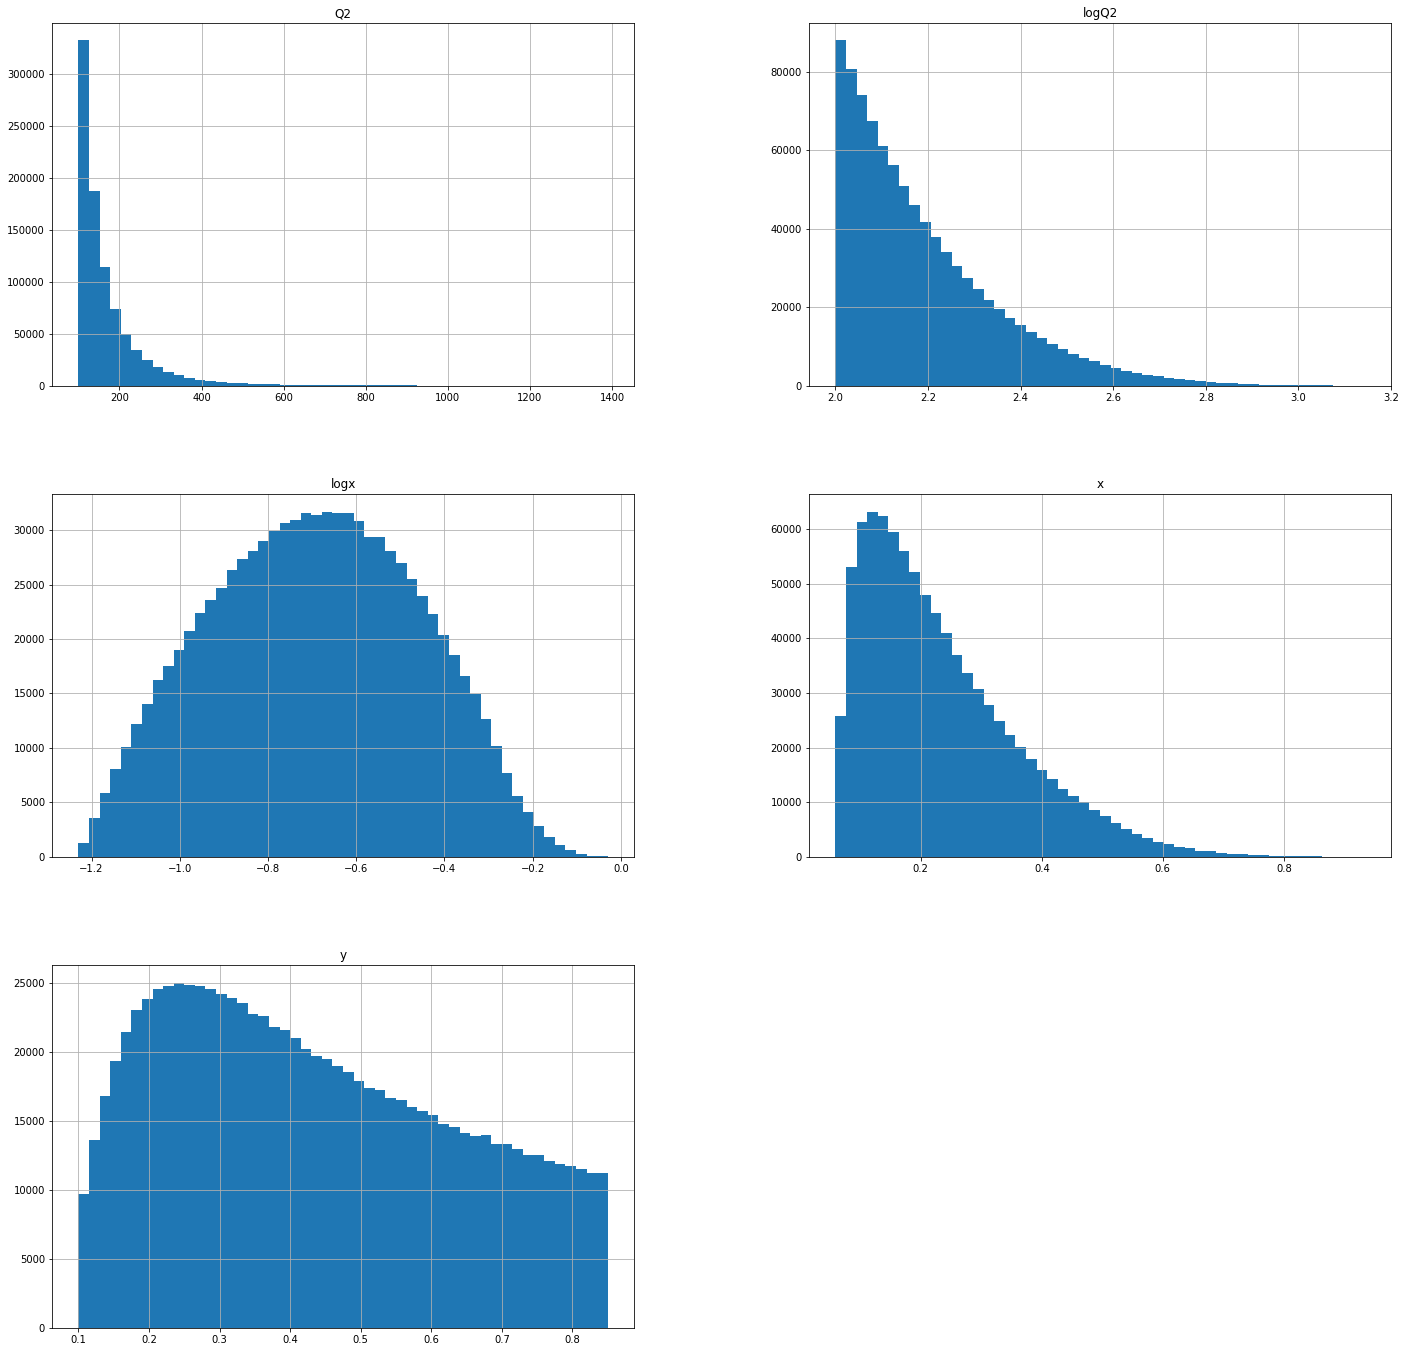

In [11]:
rc('text', usetex=False)
df.hist(figsize=(24,24),bins=50,column=['x','Q2','logx','logQ2','y'])
plt.show()

## Get jet data, apply selection

In [12]:
#df_jet      = getJetData(['NC_10_275.root'])
df_jet      = getJetData(['NC-5-100.root'])

df_jet = applyCutsJets(df_jet)


Processed NC-5-100.root in 46.3 seconds
0.1 < y < 0.85 834037  fraction kept: 97.0
Q2>100 832347  fraction kept: 99.8
jet_pt>5 832347  fraction kept: 100.0
 n>1 857216  fraction kept: 99.7


## Plot jet variables

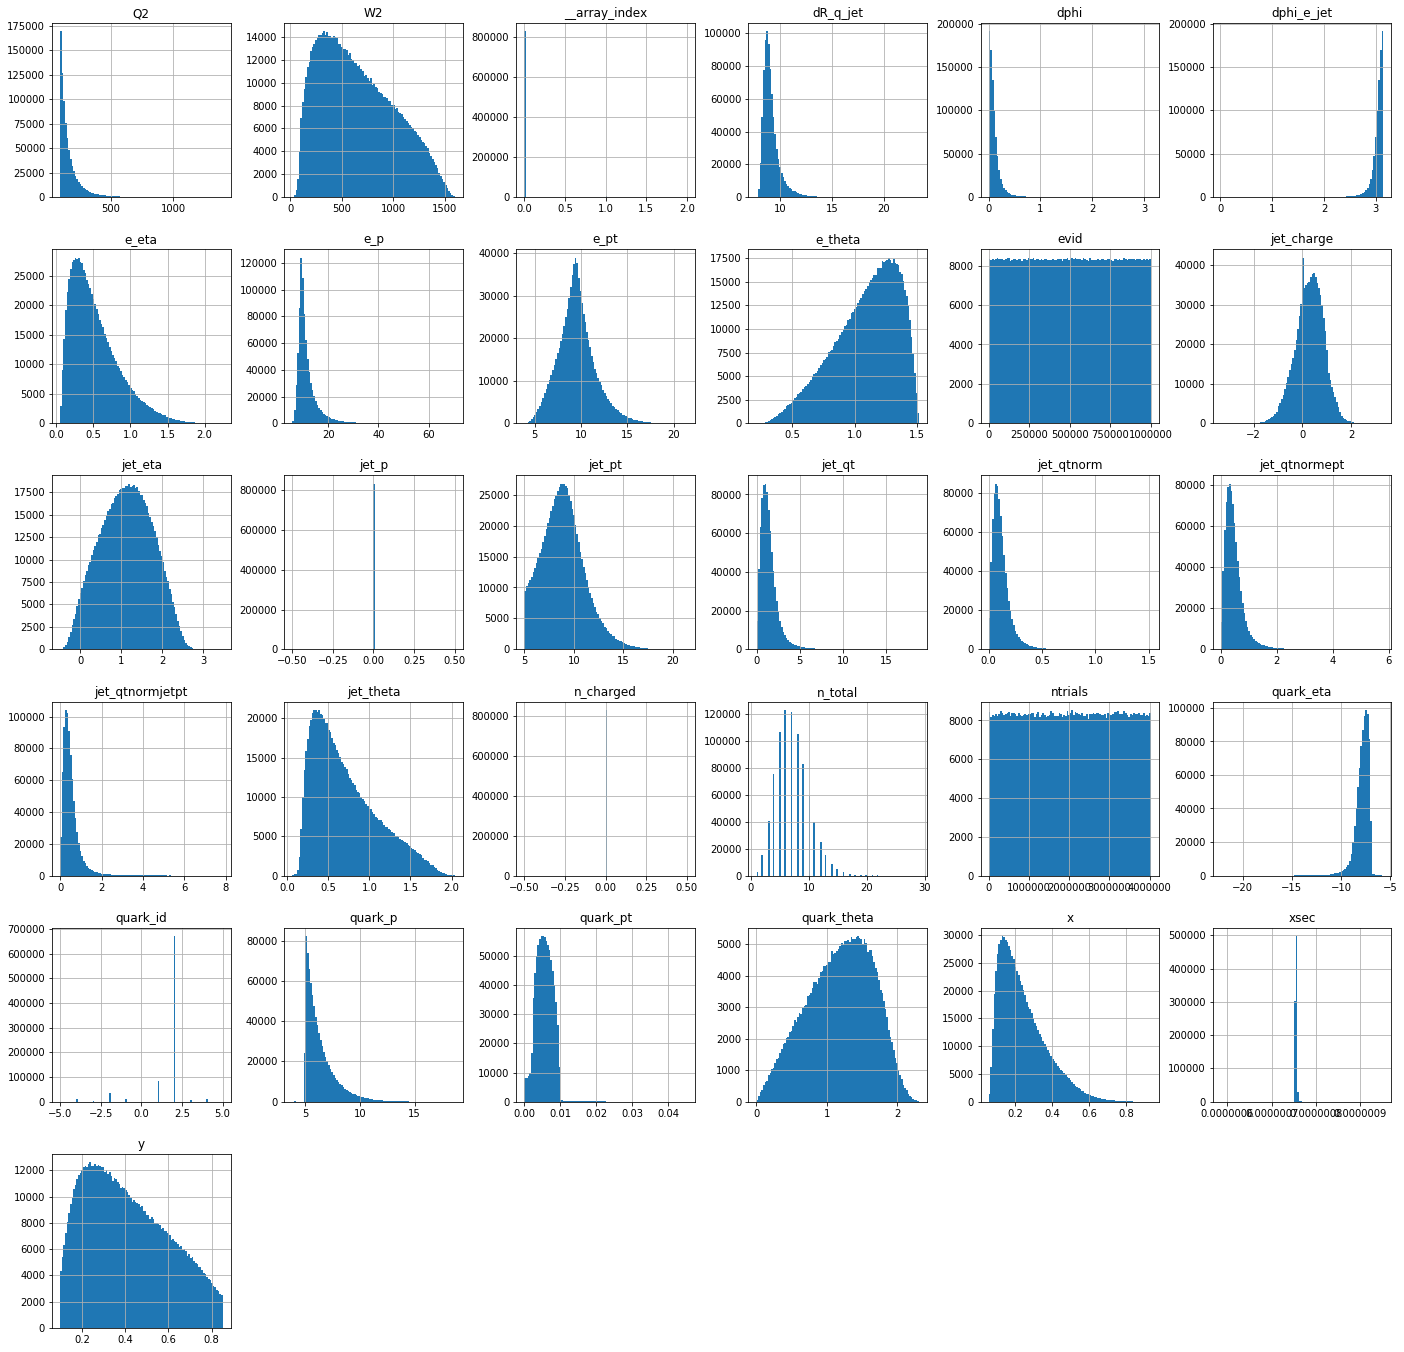

In [13]:
rc('text', usetex=False)
df_jet.hist(figsize=(24,24),bins=100)
plt.show()

## Inclusive cross-section

<Container object of 3 artists>

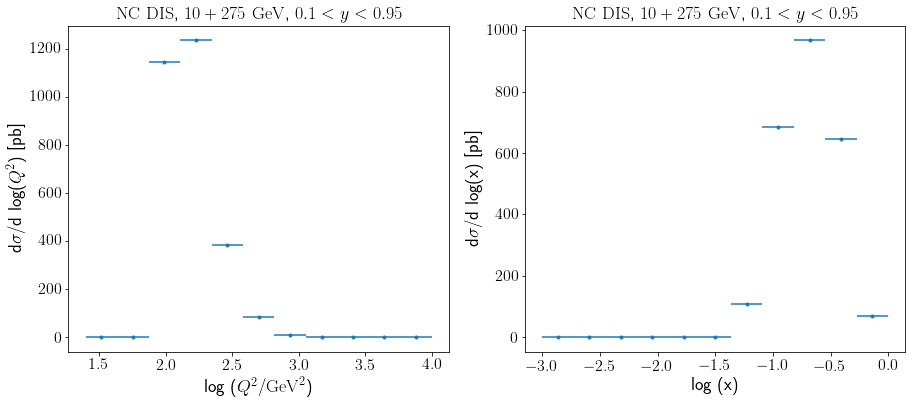

In [14]:
rc('text', usetex=True)

fig, ax1 = plt.subplots(figsize=(15,6))

##Electron distribution
plt.subplot(121)
y, x  = np.histogram(df['logQ2'],bins=np.linspace(1.4,4,12))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_cross_section
y = y/(xerr*2.0)

plt.errorbar(x,y,  xerr = xerr, fmt='.',ls='none')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('log ($Q^{2}$/$\mathrm{GeV}^{2}$)',fontsize=18)
plt.ylabel(r'd$\sigma$/d log($Q^{2}$) [pb]',fontsize=18)
plt.title('$\mathrm{NC}\ \mathrm{DIS}$, $5+100$ $\mathrm{GeV}$, $0.1<y<0.95$', fontsize=18)


plt.subplot(122)
y, x  = np.histogram(df['logx'],bins=np.linspace(-3.0,0,12))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_cross_section
y = y/(xerr*2.0)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('log (x)',fontsize=18)
plt.ylabel(r'd$\sigma$/d log(x) [pb]',fontsize=18)
plt.title('$\mathrm{NC}\ \mathrm{DIS}$, $10+275$ $\mathrm{GeV}$, $0.1<y<0.95$', fontsize=18)
plt.errorbar(x,y,  xerr = xerr, fmt='.',ls='none')

Cross section [ 6237781.01390077 10926869.57796533  3082673.79797617   101401.34119483]


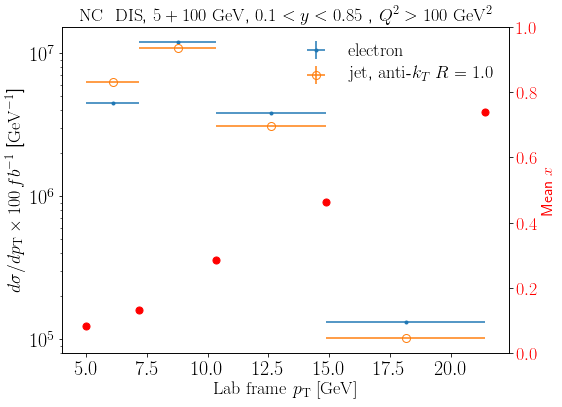

In [26]:
import seaborn as sns
nbins = 5
minpt = 5
maxpt = max(df['e_pt'])
fig, ax1 = plt.subplots(figsize=(8,6))

##Electron distribution
y, x  = np.histogram(df.query('e_pt>5')['e_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_cross_section
y = y*1000*lumi 
yerr = np.sqrt(y)

y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)

plt.errorbar(x,y, yerr=yerr,  xerr = xerr, fmt='.',ls='none',label=r'$\mathrm{electron}$')


y, x  = np.histogram(df_jet.query('jet_pt>5')['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_cross_section
y = y*1000*lumi 

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
print 'Cross section', y 
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='$\mathrm{jet}$, $\mathrm{anti}$-$k_{T}$ $R=1.0$')

plt.yscale('log')
ax1.set_xlabel(r'$\mathrm{Lab}$\ $\mathrm{frame}$ $p_{\mathrm{T}}$ $\mathrm{[GeV]}$' ,fontsize=18)
ax1.set_ylabel(r'$d\sigma/d p_{\mathrm{T}} \times 100 \, fb^{-1}$ [$\mathrm{GeV^{-1}}$]', fontsize=18)
plt.title('$\mathrm{NC}$ \ $\mathrm{DIS}$, $5+100$\ $\mathrm{GeV}$, $0.1 < y < 0.85$ , $Q^2 > 100\ \mathrm{GeV^2}$',   fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(loc='best',frameon=False,fontsize=18)#bbox_to_anchor=(0.40, 0.85

ax1.tick_params('both',labelsize=20)

###Mean x vs pT
ax2 = ax1.twinx()
ax2.tick_params(axis='y', labelcolor='red')
sns.regplot(df['e_pt'], df['x'], x_bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins),fit_reg=None,color='red')
ax2.set_ylabel('Mean $x$' ,color='red',fontsize=16)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
ax2.set_ylim([0.0,1.0])
#ax2.scale('log')



plt.savefig('CrossSection_NC.png', bbox_inches='tight')
plt.savefig('CrossSection_NC.pdf', bbox_inches='tight')

plt.legend(loc='best',frameon=False,fontsize=15,bbox_to_anchor=(0.40, 0.85))

## Flavour separated cross-sections

inclusive Cross section [ 6237781.26144771 10926870.14381785  3082673.99491508   101401.34889992]
u-jets cross section [4958389.90389189 9285495.72417116 2737827.19980691   93982.58354451]
Cross section [ 834518.81541609 1250828.38239589  281489.94527174    6586.75428752]
Cross section [112585.88892267 113870.39520798  21529.02664345    427.56124322]
djets to inclusive [0.13378456 0.1144727  0.09131356 0.06495726]


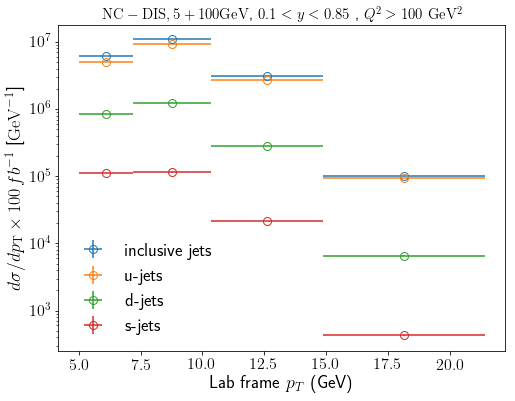

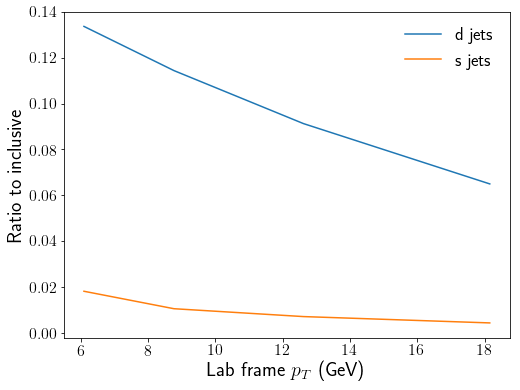

In [24]:
import seaborn as sns
nbins = 5
minpt = 5
maxpt = df['e_pt'].max()
fig, ax1 = plt.subplots(figsize=(8,6))

##Electron distribution
#y, x  = np.histogram(df_inclusive.query('e_pt>5')['e_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
#xerr = (x[1:] - x[:-1])/2.0
#x = (x[1:]+x[:-1])/2
#y = y*to_counts
#yerr = np.sqrt(y)

#y = y/(xerr*2.0)
#yerr = yerr/(xerr*2.0)

#plt.errorbar(x,y, yerr=yerr,  xerr = xerr, fmt='.',ls='none',label=r'$\nu$')


##Inclusive

y, x  = np.histogram(df_jet.query('jet_pt>5')['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
inclusive = y 
print 'inclusive Cross section', y 
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='inclusive jets')

y, x  = np.histogram(df_jet.query('jet_pt>5 and abs(quark_id)==2')['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
ujets = y
print 'u-jets cross section', ujets
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='u-jets')



y, x  = np.histogram(df_jet.query('jet_pt>5 and abs(quark_id)==1')['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
djets = y
print 'Cross section', djets
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='d-jets')



y, x  = np.histogram(df_jet.query('jet_pt>5 and abs(quark_id)==3')['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
sjets = y
print 'Cross section', sjets
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='s-jets')

plt.yscale('log')
ax1.set_xlabel('Lab frame $p_{T}$ (GeV)' ,fontsize=18)
ax1.set_ylabel(r'$d\sigma/d p_{\mathrm{T}} \times 100 \, fb^{-1}$ [$\mathrm{GeV^{-1}}$]', fontsize=18)
#plt.title('$\mathrm{CC-DIS}, 10+275 \mathrm{GeV}$, $0.01 < y < 0.9$ , $Q^2 > 100\ \mathrm{GeV^2}$',   fontsize=15)
plt.title('$\mathrm{NC-DIS}, 5+100 \mathrm{GeV}$, $0.1 < y < 0.85$ , $Q^2 > 100\ \mathrm{GeV^2}$',   fontsize=15)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc='best',frameon=False,fontsize=18)#bbox_to_anchor=(0.40, 0.85


#ax1.set_ylim([1e3,1e5])

###Mean x vs pT
#ax2 = ax1.twinx()
#ax2.tick_params(axis='y', labelcolor='grey')
#sns.regplot(df_inclusive['e_pt'], df_inclusive['x'], x_bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins),fit_reg=None,color='grey')
#ax2.set_ylabel('Mean x' ,color='grey',fontsize=16)
#plt.yticks(fontsize=16)
#plt.xticks(fontsize=16)
#ax2.set_ylim([0.0,1.0])
##ax2.scale('log')
plt.savefig('CrossSection_NC_flavourseparated.png', bbox_inches='tight')
plt.savefig('CrossSection_NC_flavourseparated.pdf', bbox_inches='tight')

djets_to_inclusive = djets/inclusive
sjets_to_inclusive = sjets/inclusive

print 'djets to inclusive', djets_to_inclusive



fig, ax1 = plt.subplots(figsize=(8,6))
plt.plot(x,djets_to_inclusive ,label='d jets' )
plt.plot(x,sjets_to_inclusive, label =' s jets')

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc='best',frameon=False,fontsize=18)#bbox_to_anchor=(0.40, 0.85
plt.xlabel('Lab frame $p_{T}$ (GeV)' ,fontsize=20)
plt.ylabel('Ratio to inclusive',fontsize=20)
plt.savefig('CrossSection_NC_flavourseparated_ratio.png', bbox_inches='tight')
plt.savefig('CrossSection_NC_flavourseparated_ratio.pdf', bbox_inches='tight')
#plt.legend(loc='best',frameon=False,fontsize=15,bbox_to_anchor=(0.40, 0.85))

inclusive Cross section [821856.34380132 988574.88870644 204633.81386427   4356.50239718]
u-jets cross section [504503.14895604 569615.06664003 118118.7137465    2565.36745935]
Cross section [230229.88471319 349432.15164641  76989.12925546   1652.46642652]
Cross section [22365.7786674  20903.74404784  3258.44727577    80.88996493]
djets to inclusive [0.28013398 0.35347059 0.37622878 0.37931034]


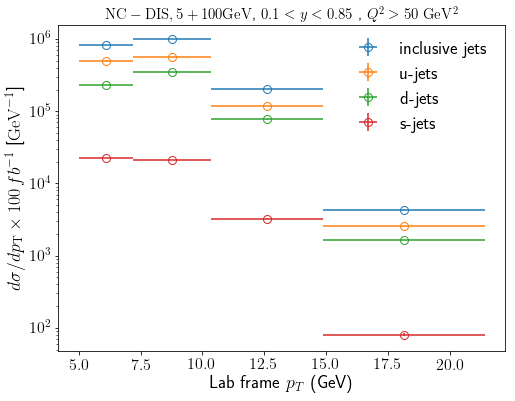

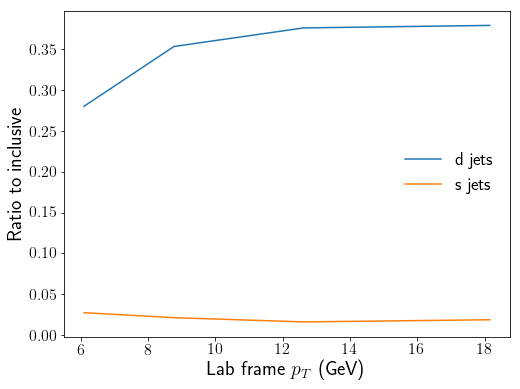

In [23]:
import seaborn as sns
nbins = 5
minpt = 5
maxpt = df['e_pt'].max()
fig, ax1 = plt.subplots(figsize=(8,6))

df_temp = df_jet.query('jet_pt>5 and jet_charge<-0.5')

y, x  = np.histogram(df_temp['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
inclusive = y 
print 'inclusive Cross section', y 
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='inclusive jets')

y, x  = np.histogram(df_temp.query('abs(quark_id)==2')['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
ujets = y
print 'u-jets cross section', ujets
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='u-jets')



y, x  = np.histogram(df_temp.query('abs(quark_id)==1')['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
djets = y
print 'Cross section', djets
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='d-jets')



y, x  = np.histogram(df_temp.query('abs(quark_id)==3')['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
sjets = y
print 'Cross section', sjets
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='s-jets')

plt.yscale('log')
ax1.set_xlabel('Lab frame $p_{T}$ (GeV)' ,fontsize=18)
ax1.set_ylabel(r'$d\sigma/d p_{\mathrm{T}} \times 100 \, fb^{-1}$ [$\mathrm{GeV^{-1}}$]', fontsize=18)
#plt.title('$\mathrm{CC-DIS}, 10+275 \mathrm{GeV}$, $0.01 < y < 0.9$ , $Q^2 > 100\ \mathrm{GeV^2}$',   fontsize=15)
plt.title('$\mathrm{NC-DIS}, 5+100 \mathrm{GeV}$, $0.1 < y < 0.85$ , $Q^2 > 50\ \mathrm{GeV^2}$',   fontsize=15)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc='best',frameon=False,fontsize=18)#bbox_to_anchor=(0.40, 0.85


#ax1.set_ylim([1e3,1e5])

###Mean x vs pT
#ax2 = ax1.twinx()
#ax2.tick_params(axis='y', labelcolor='grey')
#sns.regplot(df_inclusive['e_pt'], df_inclusive['x'], x_bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins),fit_reg=None,color='grey')
#ax2.set_ylabel('Mean x' ,color='grey',fontsize=16)
#plt.yticks(fontsize=16)
#plt.xticks(fontsize=16)
#ax2.set_ylim([0.0,1.0])
##ax2.scale('log')
plt.savefig('CrossSection_NC_flavourseparated.png', bbox_inches='tight')
plt.savefig('CrossSection_NC_flavourseparated.pdf', bbox_inches='tight')

djets_to_inclusive = djets/inclusive
sjets_to_inclusive = sjets/inclusive

print 'djets to inclusive', djets_to_inclusive



fig, ax1 = plt.subplots(figsize=(8,6))
plt.plot(x,djets_to_inclusive ,label='d jets' )
plt.plot(x,sjets_to_inclusive, label =' s jets')

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc='best',frameon=False,fontsize=18)#bbox_to_anchor=(0.40, 0.85
plt.xlabel('Lab frame $p_{T}$ (GeV)' ,fontsize=20)
plt.ylabel('Ratio to inclusive',fontsize=20)
plt.savefig('CrossSection_NC_flavourseparated_ratio.png', bbox_inches='tight')
plt.savefig('CrossSection_NC_flavourseparated_ratio.pdf', bbox_inches='tight')
#plt.legend(loc='best',frameon=False,fontsize=15,bbox_to_anchor=(0.40, 0.85))

In [35]:
df_jet.query('jet_pt>15')['x'].describe()

count    7976.000000
mean        0.565799
std         0.098983
min         0.189691
25%         0.496053
50%         0.556467
75%         0.628156
max         0.933634
Name: x, dtype: float64

(array([  11.,   38.,  538., 2615., 2780., 1942., 1465., 1051.,  255.,
          23.]),
 array([ 5.116786 ,  6.7488885,  8.380991 , 10.013094 , 11.645197 ,
        13.2773   , 14.909402 , 16.541504 , 18.173607 , 19.80571  ,
        21.437813 ], dtype=float32),
 <a list of 10 Patch objects>)

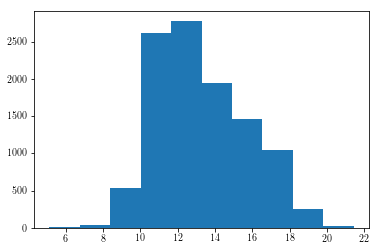

In [32]:
plt.hist(df_jet.query('x>0.6')['jet_pt'])


## Maximum pT

In [ ]:
print max(df['e_pt'])
print min(df['Q2'])

In [ ]:
n = df.query('x>0.1 and x<0.2 and y<0.85').shape[0]
print n*to_counts

jets = df_jet.query('x>0.1 and x<0.2 and y<0.85').shape[0]
jets = jets*to_counts
print jets
jets = df_jet.query('x>0.1 and x<0.2 and y>0.1 and y<0.85 and jet_qtnormjetpt<0.3').shape[0]
jets = jets*to_counts
print jets

print df_jet.query('x>0.1 and x<0.2 and y>0.1 and y<0.85 and jet_qtnormjetpt<0.3')['jet_pt'].mean()
print df_jet.query('x>0.1 and x<0.2 and y>0.1 and y<0.85 and jet_qtnormjetpt<0.3')['n_total'].mean()
#print df_jet.query('x>0.1 and x<0.2 and y>0.1 and y<0.85 and jet_qtnormjetpt<0.3')['n_charged'].mean()

print 'number'
print df_jet.query('jet_pt>10 and jet_pt<12')['n_total'].mean()

plt.hist(df_jet.query('x>0.1 and x<0.2 and y>0.1 and y<0.85 and jet_qtnormjetpt<0.3')['jet_pt'])

In [ ]:
jets = df_jet.query('jet_pt>10 and jet_pt<15 and y<0.85 and y>0.1 and jet_qtnormjetpt<0.3').shape[0]
jets = jets*to_counts
print jets

## Sivers asymmetry for lepton-jet correlation!

In [ ]:
dilution_factor =0.7 # proton polarization for single-spin asymmetries ()
efficiency = 0.5 #overall-efficiency
penalty = 1.0 #sqrt(2) coming from separating Sivers v Collins v something else
lumi = 100 # in units of fb-1. 100 is expected in a year? (check)

def fake_A(x,slope=0.05):
    return slope*np.ones(len(x))

In [ ]:
rc('text', usetex=True)

fig = plt.figure(figsize=(8,6))
asymmetry = [0.125,0.1,0.075,0.05,0.025]
asymmetry = np.divide(asymmetry,2.0)
#colores = ['black','blue','red','purple']



#for counter,edges in enumerate([(100,200),(200,500), (500,1000),(1000,2000), (2000,10000)]):
for counter,edges in enumerate([(25,50),(50,100),(100,200),(200,500), (500,1000)]):

    df_cut = df_jet.query('dphi<0.4 and Q2 > %2.2f and Q2<%2.2f'%(edges[0],edges[1]))
    print df_cut['e_pt'].mean(), ' mean pt'
    print df_cut['jet_pt'].mean(), ' mean pt'

    print df_cut['x'].mean(), ' mean x'
    print df_cut['Q2'].mean(), ' mean Q2'
    
    print 'Number of events ', df_cut.shape[0]*to_cross_section*1000*lumi 
    
    print '###########'
    y, x  = np.histogram(df_cut['x'],bins=np.logspace(-2,-0.09,12))
    x = (x[1:]+x[:-1])/2
    x = x + 0.01*counter
    #y[y<100] = 0
    #print y
    y = y*to_cross_section
    y = y*1000*lumi
    print y 
    
    y = y*efficiency # take efficiency hit
    erry = np.divide(1,dilution_factor*np.sqrt(y),out=np.zeros_like(y)) #follow standard formula for asymmetry uncertainty
    print 'error', erry
    x[erry == inf] = 1000
    print x
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none',label='%2.0f$<Q^{2}<$%2.0f $\mathrm{GeV}^{2}$'%(edges[0],edges[1]))
    #print 'error', erry
    #print x
    
    #plt.errorbar(x,y,label='%2.0f$<Q^{2}<$%2.0f'%(edges[0],edges[1]))

    #plt.errorbar(x,y,label='%2.2f$<x<$%2.2f'%(edges[0],edges[1]))
####
plt.ylim([0.0,0.10])
plt.xlim([0.01,1.0])
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.yscale('log')

plt.xscale('log')
plt.title('$e+p$ NC DIS, 10+100 GeV, 100 fb$^{-1}$, $0.01<y<0.95$', fontsize=18)
plt.legend(loc='best', fontsize=16,frameon=False,ncol=2)
plt.ylabel('$A_{UT}$',fontsize=18)
plt.xlabel('$x$',fontsize=20)
plt.savefig('AUT_NC_Sivers_xdependence.png', bbox_inches='tight')
plt.savefig('AUT_NC_Sivers_xdependence.pdf', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04,0.07]
colores = ['black','blue','red','purple']
for counter,edges in enumerate([(0.05,0.1), (0.15,0.2),(0.2,0.3),(0.3,0.8)]):
    maxdphi = 0.15
    df_cut = df_jet.query('x > %2.2f and x<%2.2f'%(edges[0],edges[1]))
    print df_cut['e_pt'].mean(), ' mean pt'
    print df_cut['x'].mean(), ' mean x'
    print df_cut['Q2'].mean(), ' mean Q2'

    y, x  = np.histogram(df_cut['dphi'],bins=5,range=(0.0,maxdphi))
    x = (x[1:]+x[:-1])/2
    y = y*to_cross_section
    y = y*1000*lumi
    erry = 1/(dilution_factor*np.sqrt(y)) #follow standard formula for asymmetry uncertainty
    erry= penalty*erry #take sqrt(2) because of interference with other modulations
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none',color=colores[counter],label='%2.2f$<x<$%2.2f'%(edges[0],edges[1]))
    print ' '
####
plt.ylim([0.0,0.12])
plt.xlim([0.0,0.15])

plt.text(0.01, 0.1, '$e+p^{\uparrow}$, 10+100 GeV, 100 fb$^{-1}$ \n $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$', fontsize=18)
plt.legend(loc='best', fontsize=16,frameon=False,ncol=1)
plt.ylabel('$A_{UT}$',fontsize=18)
plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.savefig('AUT_Sivers_xbins.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_xbins.pdf', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04]
colores = ['black','blue','red']
for counter,edges in enumerate([(6.0,8.0), (9,11),(13.0,17.0)]):
    maxdphi = np.pi
    df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    print df_cut['e_pt'].mean(), ' mean pt'
    y, x  = np.histogram(df_cut['dphi'],bins=7,range=(0.0,0.4))
    x = (x[1:]+x[:-1])/2
    y = y*to_cross_section
    y = y*1000*lumi
    erry = np.sqrt(y)
    plt.errorbar(x,y ,fmt='o',ls='none',color=colores[counter],label='%2.0f$<p_{T}^{e}<$%2.0f'%(edges[0],edges[1]))

####
plt.legend(frameon=False,loc='best')
#plt.ylim([0.0,0.07])

#plt.text(0.01, 0.05, '$e+p^{\uparrow}$, 18+100 GeV \n $0.1<y<0.85$, $Q^{2}>$25 GeV$^{2}$\n 100 fb$^{-1}$', fontsize=18)
plt.legend(loc='best', fontsize=20,frameon=False)
plt.ylabel('$d\sigma $x 100 fb$^{-1}$',fontsize=18)
plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.savefig('AUT_Sivers_distributions.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_distributions.pdf', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8,6))
asymmetry = [0.01,0.02,0.04,0.06]
colores = ['black','blue','red','purple']
for counter,edges in enumerate([(6.0,8.0), (9,11),(13.0,17.0)]):
    maxdphi = 0.15
    df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    print df_cut['e_pt'].mean(), ' mean pt'
    mean_x = df_cut['x'].mean()
    print mean_x
    
    print df_cut['Q2'].mean(), ' mean Q2'

    y, x  = np.histogram(df_cut['dphi'],bins=7,range=(0.0,maxdphi))
    x = (x[1:]+x[:-1])/2
    y = y*to_cross_section
    y = y*1000*lumi
    y = y*efficiency # take efficiency hit
    erry = 1/(dilution_factor*np.sqrt(y)) #follow standard formula for asymmetry uncertainty
    erry= penalty*erry #take sqrt(2) because of interference with other modulations
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none', color=colores[counter],label='%2.0f$<p_{T}^{e}<$%2.0f GeV, $<x>$ = %2.2f'%(edges[0],edges[1],mean_x))
    print ' '
####
plt.legend(frameon=False,loc='best',ncol=2,fontsize=16)
plt.ylim([0.0,0.09])
#plt.ylim([-0.15,0.15])

plt.xlim([0.0,0.15])

plt.text(0.005, 0.065, 'asdasd', fontsize=18)
plt.legend(loc='best', fontsize=16,frameon=False)
plt.ylabel('$A_{UT}$',fontsize=18)
plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.savefig('AUT_Sivers.png', bbox_inches='tight')
plt.savefig('AUT_Sivers.pdf', bbox_inches='tight')

In [ ]:
from matplotlib import rc
rc('text', usetex=True)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})


for counter,edges in enumerate([(10,15), (15,20),(20,30)]):

    df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    #printSummary(df_cut)
    print '###########'
    
    axs[counter].hist(df_cut['dphi'],bins=25,range=(0,0.4),normed=True)
    
    axs[counter].xaxis.set_label_text(r'$|\phi^{jet}-\phi^\nu-\pi|$', fontsize=25)
    axs[0].yaxis.set_label_text(r'$\mathrm{Normalized\ counts}$', fontsize=25)
    axs[counter].tick_params('both',labelsize=20)
    plt.yticks(fontsize=20)
    #axs[counter].text(0.1,6, , fontsize=20)
    #axs[counter].text(0.1,8, '$\sqrt{s} = 89 \, \mathrm{GeV}$ \n $0.1 < y < 0.85$ \n $p_T^{jet} > 4 \, \mathrm{GeV/c}$', fontsize=20)
    #plt.legend(prop={'size': 20}, frameon=False, loc='best')
    axs[counter].text(0.07,11, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
                      r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=25)

axs[1].set_title(r'NC\ DIS \ $10+275$ \ $\mathrm{GeV}$, 100 $\mathrm{fb}^{-1}$ , $0.1<y<0.85$, $Q^{2}>25$ $\mathrm{GeV}^{2}$',fontsize=25)  

plt.savefig('NC_LeptonJetAzimuthal.png', bbox_inches='tight')
plt.savefig('NC_LeptonJetAzimuthal.pdf', bbox_inches='tight')


## qT distributions without normalization

In [ ]:
from matplotlib import rc
rc('text', usetex=True)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})


for counter,edges in enumerate([(10,15), (15,20),(20,30)]):

    df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    #printSummary(df_cut)
    print '###########'
    
    axs[counter].hist(df_cut['jet_qt'],bins=25,range=(0,4.0),normed=True)
    
    axs[counter].xaxis.set_label_text(r'$q_{T} [GeV]$', fontsize=25)
    axs[0].yaxis.set_label_text(r'$\mathrm{Normalized\ counts}$', fontsize=25)
    axs[counter].tick_params('both',labelsize=20)
    plt.yticks(fontsize=20)
    #axs[counter].text(0.1,6, , fontsize=20)
    #axs[counter].text(0.1,8, '$\sqrt{s} = 89 \, \mathrm{GeV}$ \n $0.1 < y < 0.85$ \n $p_T^{jet} > 4 \, \mathrm{GeV/c}$', fontsize=20)
    #plt.legend(prop={'size': 20}, frameon=False, loc='best')
    #axs[counter].text(0.07,10, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
    #                  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=25)

axs[1].set_title(r'NC\ DIS \ $10+275$ \ $\mathrm{GeV}$, 100 $\mathrm{fb}^{-1}$ , $0.1<y<0.85$, $Q^{2}>25$ $\mathrm{GeV}^{2}$',fontsize=25)  

plt.savefig('NC_LeptonJetqt.png', bbox_inches='tight')
plt.savefig('NC_LeptonJetqt.pdf', bbox_inches='tight')

## qT distirbutions

In [ ]:
from matplotlib import rc
rc('text', usetex=True)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})


for counter,edges in enumerate([(10,15), (15,20),(20,30)]):

    df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    #printSummary(df_cut)
    print '###########'
    
    axs[counter].hist(df_cut['jet_qtnorm'],bins=25,range=(0,0.5),normed=True)
    
    axs[counter].xaxis.set_label_text(r'$q_{T}/Q$', fontsize=25)
    axs[0].yaxis.set_label_text(r'$\mathrm{Normalized\ counts}$', fontsize=25)
    axs[counter].tick_params('both',labelsize=20)
    plt.yticks(fontsize=20)
    #axs[counter].text(0.1,6, , fontsize=20)
    #axs[counter].text(0.1,8, '$\sqrt{s} = 89 \, \mathrm{GeV}$ \n $0.1 < y < 0.85$ \n $p_T^{jet} > 4 \, \mathrm{GeV/c}$', fontsize=20)
    #plt.legend(prop={'size': 20}, frameon=False, loc='best')
    axs[counter].text(0.07,10, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
                      r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=25)

axs[1].set_title(r'NC\ DIS \ $10+275$ \ $\mathrm{GeV}$, 100 $\mathrm{fb}^{-1}$ , $0.1<y<0.85$, $Q^{2}>25$ $\mathrm{GeV}^{2}$',fontsize=25)  

plt.savefig('NC_LeptonJetqt.png', bbox_inches='tight')
plt.savefig('NC_LeptonJetqt.pdf', bbox_inches='tight')


In [ ]:
from matplotlib import rc
rc('text', usetex=True)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})


for counter,edges in enumerate([(10,15), (15,20),(20,30)]):

    df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    #printSummary(df_cut)
    print '###########'
    
    axs[counter].hist(df_cut['jet_qtnormept'],bins=15,range=(0,1.0),normed=True)
    
    axs[counter].xaxis.set_label_text(r'$q_{T}/p_{\mathrm{T}}^{e}$', fontsize=25)
    axs[0].yaxis.set_label_text(r'$\mathrm{Normalized\ counts}$', fontsize=25)
    axs[counter].tick_params('both',labelsize=20)
    plt.yticks(fontsize=20)
    #axs[counter].text(0.1,6, , fontsize=20)
    #axs[counter].text(0.1,8, '$\sqrt{s} = 89 \, \mathrm{GeV}$ \n $0.1 < y < 0.85$ \n $p_T^{jet} > 4 \, \mathrm{GeV/c}$', fontsize=20)
    #plt.legend(prop={'size': 20}, frameon=False, loc='best')
    #axs[counter].text(0.07,10, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
    #                  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=25)

axs[1].set_title(r'NC\ DIS \ $10+275$ \ $\mathrm{GeV}$, 100 $\mathrm{fb}^{-1}$ , $0.1<y<0.85$, $Q^{2}>25$ $\mathrm{GeV}^{2}$',fontsize=25)  

plt.savefig('NC_LeptonJetqtoverept.png', bbox_inches='tight')
plt.savefig('NC_LeptonJetqtoverept.pdf', bbox_inches='tight')

In [ ]:
from matplotlib import rc
rc('text', usetex=True)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})


for counter,edges in enumerate([(10,15), (15,20),(20,30)]):

    df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(edges[0],edges[1]))
    #printSummary(df_cut)
    print '###########'
    
    axs[counter].hist(df_cut['jet_qtnormjetpt'],bins=10,range=(0,1.0),normed=True)
    
    axs[counter].xaxis.set_label_text(r'$q_{T}/p_{\mathrm{T}}^{jet}$', fontsize=25)
    axs[0].yaxis.set_label_text(r'$\mathrm{Normalized\ counts}$', fontsize=25)
    axs[counter].tick_params('both',labelsize=20)
    plt.yticks(fontsize=20)
    #axs[counter].text(0.1,6, , fontsize=20)
    #axs[counter].text(0.1,8, '$\sqrt{s} = 89 \, \mathrm{GeV}$ \n $0.1 < y < 0.85$ \n $p_T^{jet} > 4 \, \mathrm{GeV/c}$', fontsize=20)
    #plt.legend(prop={'size': 20}, frameon=False, loc='best')
    #axs[counter].text(0.07,10, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
    #                  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=25)

axs[1].set_title(r'NC\ DIS \ $10+275$ \ $\mathrm{GeV}$, 100 $\mathrm{fb}^{-1}$ , $0.1<y<0.85$, $Q^{2}>25$ $\mathrm{GeV}^{2}$',fontsize=25)  

plt.savefig('NC_LeptonJetqtoverept.png', bbox_inches='tight')
plt.savefig('NC_LeptonJetqtoverept.pdf', bbox_inches='tight')

In [ ]:
## Single unpolarized plot

In [ ]:
rc('text', usetex=True)


fig = plt.figure(figsize=(8,6))


df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(15,20))
printSummary(df_cut)
print '###########'
    
plt.hist(df_cut['jet_qtnormjetpt'],bins=10,range=(0,1.05),normed=True,histtype='step')    
plt.xlabel(r'$q_{T}/p_{\mathrm{T}}^{jet}$', fontsize=25)
plt.ylabel(r'$1/\sigma_{\mathrm{DIS}} \times d\sigma/dq_{T}$ $\ \mathrm{ GeV}^{-1}$ ', fontsize=25)
#plt.tick_params('both',labelsize=20)

plt.text(0.45,1.5, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(15,20) + '$\ \mathrm{ GeV}$ \n' +
                      r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=21)

plt.legend(loc='best',frameon=False)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.savefig('qtplot.png', bbox_inches='tight')
plt.savefig('qtplot.pdf', bbox_inches='tight')

## qT 

In [ ]:
rc('text', usetex=True)


fig = plt.figure(figsize=(8,6))


df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(15,20))
printSummary(df_cut)
print '###########'
    
#plt.hist(df_cut['jet_qt'],bins=10,range=(0,4.0),normed=True,histtype='step')    

y, x  = np.histogram(df_cut['jet_qt'],bins=10,range=(0,4.0))
width = (x[1:]-x[:-1])
x = (x[1:]+x[:-1])/2.0
y = y*to_cross_section
y = y/width
plt.errorbar(x,y , xerr=width/2.0, fmt='o',ls='none')


plt.xlabel(r'$q_{T}$ (GeV)', fontsize=25)
plt.ylabel(r'$d\sigma/dq_{T}$ [pb/GeV] ', fontsize=25)
#plt.tick_params('both',labelsize=20)

plt.title(r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(15,20) + '$\ \mathrm{ GeV}$ \n' +
                      r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=21)

plt.legend(loc='best',frameon=False)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.savefig('qtplot.png', bbox_inches='tight')
plt.savefig('qtplot.pdf', bbox_inches='tight')

In [ ]:
nbins  = 4
df_cut = df_jet.query('e_pt > %2.2f and e_pt <%2.2f'%(15,20))
printSummary(df_cut)

x_Sivers = np.array([1.00E-01,3.00E-01 ,5.00E-01, 7.00E-01  , 9.00E-01,1.10E+00 ,1.30E+00 ,1.50E+00,2.00E+00 ,3.00E+00, 5.00E+00])
x_Sivers = np.divide(x_Sivers,16.0)
ySivers  = np.array([1.15E-01, 9.64E-01, 2.32E+00 , 3.68E+00, 4.60E+00, 4.88E+00, 4.59E+00,  3.94E+00,  2.23E+00,  1.04E+00, 1.53E-01])
yunpol = np.array([2.47E+01,  7.04E+01,  1.06E+02,  1.29E+02,  1.37E+02,  1.35E+02,  1.25E+02, 1.11E+02, 7.71E+01, 3.83E+01, 1.15E+01])


ySivers = np.divide(ySivers,yunpol)
print ySivers

from matplotlib import rc
rc('text', usetex=True)
maxz = 0.8
#fig = plt.figure(figsize=(9,4.5))
fig = plt.figure(figsize=(8,6))
plt.plot(x_Sivers, ySivers,label='$15 < p_{\mathrm{T}}^{\mathrm{jet}}<20 \mathrm{~GeV}$',color='red')


y, x  = np.histogram(df_cut['jet_qtnormjetpt'],bins=nbins,range=(0.0,0.4))
x = (x[1:]+x[:-1])/2
y = y*to_counts
y = y*efficiency # take efficiency hit
y[y<100] = 0

erry = np.divide(1,dilution_factor*np.sqrt(y),out=np.zeros_like(y)) #follow standard formula for asymmetry uncertainty
erry= penalty*erry #take sqrt(2) because of interference with other modulations
x[erry == inf] = 1000

plt.errorbar(x,y=np.zeros(len(x)) , yerr=erry, fmt='o',ls='none',color='black')
print ' '

plt.title('$e+p^{\uparrow}$, $10+275 \mathrm{ ~GeV}$, $100$ $\mathrm{fb}$^{-1}$', fontsize=20)
#plt.text(0.07, 0.040, '$0.1<x<0.2$, $0.1<y<0.85$ ',fontsize=17)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.axhline(y=0.0,color='black',linestyle='--',alpha=0.5)

plt.ylim([-0.01,0.05])


lg= plt.legend(loc='best', fontsize=18,frameon=False,ncol=2,title='Arratia, Kang, Prokudin, Ringer (prelim)')
title = lg.get_title()
title.set_fontsize(19)
plt.ylabel('$A_{\mathrm{UT}}^{\sin(\phi_S-\phi_\mathrm{jet})}$',fontsize=25)
#plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.xlabel(r'$q_{T}/p_{\mathrm{T}}^{jet}$', fontsize=25)

plt.savefig('AUT_Sivers_qtbins.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_qtbins.pdf', bbox_inches='tight')

In [ ]:
rc('text', usetex=True)

fig = plt.figure(figsize=(8,6))
x_theory= [0.10E-01 ,0.20E-01 ,0.40E-01,0.60E-01,0.80E-01,0.10E+00,0.15E+00,0.20E+00,0.25E+00,0.30E+00,0.35E+00]
y_theory = [0.797E-02, 0.156E-01,  0.286E-01,0.343E-01 , 0.353E-01 , 0.341E-01, 0.286E-01,  0.236E-01 ,0.199E-01 ,0.174E-01, 0.156E-01    ]

ymin_theory = [0.111E-01,0.217E-01,0.384E-01 ,0.459E-01,0.478E-01,0.471E-01,0.419E-01,0.366E-01,0.326E-01 ,0.297E-01, 0.276E-01 ]

ymax_theory = [0.458E-02,0.855E-02,  0.169E-01, 0.207E-01, 0.209E-01,0.194E-01,0.139E-01,0.959E-02,0.674E-02,0.489E-02,0.366E-02]


plt.fill_between(x_theory, ymin_theory , ymax_theory,alpha=0.7,color='orange',label='theory uncertainty')     
plt.plot(x_theory,y_theory,linewidth=3,color='red')
plt.ylabel('$A_{\mathrm{UT}}^{\sin(\phi_S-\phi_\mathrm{q})}$',fontsize=25)
#plt.xlabel('$\Delta\phi = \pi-|\phi_{e}-\phi_{jet}|$',fontsize=20)
plt.xlabel(r'$q_{T}/p_{\mathrm{T}}^{e}$', fontsize=25)

plt.errorbar(x,y=np.zeros(len(x)) , yerr=erry, fmt='o',ls='none',color='black',label='projected precision')

y_theory_subset = [0.0286,0.0341,0.0236,0.0199,0.0174]
#plt.errorbar(x, y_theory_subset , yerr=erry, fmt='o',ls='none',color='black')

print x
print x_theory
print y_theory
plt.title('$e+p^{\uparrow}$, $10+275 \mathrm{ ~GeV}$, $100$ $\mathrm{fb}$^{-1}$, $0.1<y<0.85$', fontsize=20)
#plt.text(0.07, 0.040, '$0.1<x<0.2$, $0.1<y<0.85$ ',fontsize=17)
plt.yticks(fontsize=19)
plt.xticks(fontsize=19)
plt.legend(fontsize=18,frameon=False,ncol=2)
plt.text(0.18,0.042, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(15,20) + '$\ \mathrm{ GeV}$ \n' +
                      r'$\langle x \rangle=%2.2f, \langle Q^{2} \rangle=%2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=19)

plt.ylim([-0.005,0.06])
plt.savefig('AUT_Sivers_qtbins_theoryerror.png', bbox_inches='tight')
plt.savefig('AUT_Sivers_qtbins_theoryerror.pdf', bbox_inches='tight')
plt.show()

In [ ]:
xtheory = np.array([1.00E-01,   3.00E-01, 5.00E-01, 7.00E-01,  9.00E-01, 1.10E+00,  1.30E+00, 1.50E+00,   2.00E+00,  3.00E+00,    5.00E+00])
ytheory = np.array([2.47E+01,  7.04E+01, 1.06E+02, 1.29E+02, 1.37E+02, 1.35E+02, 1.25E+02, 1.11E+02, 7.71E+01, 3.83E+01,   1.15E+01])

ytheory = ytheory/302.0
plt.plot(xtheory,ytheory)



In [ ]:
fig = plt.figure(figsize=(8,6))

xpythia =  np.linspace(0.0,5.0,26)
binwidth = (xpythia[1:]-xpythia[:-1])/2
print binwidth

xpythia = (xpythia[1:]+xpythia[:-1])/2
ypythia_qt = np.array([0.0729561, 0.210884, 0.334565, 0.405329,
      0.451357,  0.478129,  0.4476, 0.406112,  0.357736,
     0.310455, 0.259417, 0.219808, 0.187557,0.152331, 0.117419,
     0.102233,  0.0781226,  0.079375, 0.0599618, 0.0583962, 0.0483765,
    0.0474371, 0.0378871, 0.0405486,  0.0360084])

plt.errorbar(x, ypythia_qt, xerr=binwidth,label='Pythia')
plt.plot(xtheory,ytheory, label='theory')
plt.legend()

#plt.title('$e+p^{\uparrow}$, $10+275 \mathrm{ ~GeV}$, $100$ $\mathrm{fb}$^{-1}$', fontsize=20)
#plt.text(0.07, 0.040, '$0.1<x<0.2$, $0.1<y<0.85$ ',fontsize=17)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=20,frameon=False)
plt.xlabel(r'$q_{T}$ [GeV]', fontsize=25)
plt.text(2.1,0.33, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(15,20) + '$\ \mathrm{ GeV}$ \n' +
                      r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=21)

plt.ylabel(r'$1/\sigma_{\mathrm{DIS}} \times d\sigma/dq_{T}$ $\ \mathrm{ GeV}^{-1}$ ', fontsize=25)


In [ ]:
rc('text', usetex=True)
fig = plt.figure(figsize=(8,6))
df_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(15,20))
printSummary(df_cut)
print '###########'
    
#plt.hist(df_cut['jet_qt'],bins=10,range=(0,4.0),normed=True,histtype='step')    

y, x  = np.histogram(df_cut['jet_qt'],bins=20,range=(0,5.0))
width = (x[1:]-x[:-1])
x = (x[1:]+x[:-1])/2.0
y = y*to_cross_section
y = y/sum(y)
y = y/width

#plt.errorbar(x,y , xerr=width/2.0, fmt='o',ls='none',label='Pythia')

plt.step(x,y , where='mid',label='Pythia')


plt.xlabel(r'$q_{T}$ $\mathrm{[GeV]}$', fontsize=25)
plt.ylabel(r'$d\sigma/dq_{T}$ [pb/GeV] ', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.text(2.3,0.30, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(15,20) + '$\ \mathrm{ GeV}$ \n' +
                      r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=20)

plt.ylabel(r'$1/\sigma \times d\sigma/dq_{T}$ ', fontsize=25)
plt.plot(xtheory,ytheory, label='theory',linewidth=3,alpha=0.7)
plt.legend(fontsize=20,frameon=False)


plt.savefig('Unpolarized_qt.png', bbox_inches='tight')
plt.savefig('Unpolarized_qt.pdf', bbox_inches='tight')


In [ ]:
rc('text', usetex=True)
fig = plt.figure(figsize=(8,6))

x = np.linspace(0.0,1.0,21)
width = (x[1:]-x[:-1])/2.0

x = (x[1:]+x[:-1])/2.0
y = np.array([29.8717, 24.6772, 13.4533,  8.31625,5.50283,3.69649, 2.68424, 1.86547,1.37743, 1.01513, 0.768237,0.569575,0.429478, 0.322682, 0.232538,0.17627,
    0.124594, 0.0912927,0.0631585, 0.0269859])

print len(x)
#print x
#print width

#print len(width)
print len(x)
print len(y)
xtheory = np.array([5.00E-02  , 6.00E-02,7.00E-02,8.00E-02,9.00E-02,1.00E-01,1.30E-01,    1.60E-01,2.00E-01,2.50E-01,3.00E-01,4.00E-01,5.00E-01,6.00E-01, 7.00E-01,8.00E-01,9.00E-01 ])  
ytheory = np.array([2.00E+01,1.95E+01, 1.85E+01,1.72E+01,1.59E+01,1.46E+01,1.16E+01,9.16E+00,6.78E+00,4.74E+00,3.31E+00,1.69E+00,9.05E-01, 5.08E-01,2.92E-01,1.54E-01,6.64E-02])

#plt.errorbar(x,y,xerr=width,fmt='o',ls='none',label='Pythia')
plt.step(x,y,where='mid',label='Pythia')
plt.errorbar(xtheory,ytheory,label='theory',linewidth=3,alpha=0.7)


plt.yscale('log')
plt.xscale('log')

z_str = r'$z_{h} = |\vec{p}_{\mathrm{jet}} \cdot \vec{p}_{\mathrm{hadron}}| \left/ |\vec{p}_{\mathrm{jet}}|^2 \right.$'

plt.xlabel(z_str, fontsize=25)
plt.ylabel(r'$1/\sigma \times d\sigma/dz_h$ ', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=20,frameon=False)
plt.xlim([0.05,1.1])
#plt.title(r'$e+p,$~$10+275$ $\mathrm{~GeV}$', fontsize=20)
plt.text(0.06,.10, r'$15<p_{\mathrm{T}}^{e} <20$  $\mathrm{~GeV}$,', fontsize=20)
plt.text(0.06,.05, r'$0.1<y<0.85$', fontsize=20)

plt.savefig('Unpolarized_z.pdf', bbox_inches='tight')
plt.savefig('Unpolarized_z.pdf', bbox_inches='tight')

In [ ]:
rc('text', usetex=True)
fig = plt.figure(figsize=(8,6))
#xpythia = np.array([0.05, 0.15,0.25 ,0.35 , 0.45, 0.55 ,0.65,   0.75,0.85,0.95,  1.05,  1.15, 1.25,1.35,   1.45 , 1.55 ,1.65 ,1.75, 1.85 
#           ,1.95, 2.05, 2.15 ,2.25, 2.35,  2.45,2.55,2.65 ,2.75  , 2.85 ,  2.95 ])

xpythia = np.linspace(0.0,3.0,31)
width = (xpythia[1:]-xpythia[:-1])/2.0
xpythia = (xpythia[1:]+xpythia[:-1])/2.0


ypythia = np.array([0.701346,  1.90308, 2.66816, 2.85936, 2.6139, 2.13275, 1.63781,  1.17331, 0.869865,
           0.608905,  0.435507, 0.328998, 0.236844, 0.177992, 0.135504, 0.115695, 0.082106, 0.0677518,
           0.0462205, 0.037608, 0.0275601, 0.0258376,  0.017225, 0.0117704,  0.00746419, 0.00861252,
            0.00631585,   0.00516751,   0.00258376,    0.0017225])


xtheory =  np.array([5.00E-02 , 1.00E-01, 2.00E-01,    3.00E-01 ,  4.00E-01 ,  5.00E-01 ,  6.00E-01, 7.00E-01,8.00E-01,9.00E-01 , 1.00E+00 ,
            1.10E+00,  1.20E+00 ,  1.30E+00 ,  1.40E+00  , 1.50E+00 ])

ytheory = np.array([5.59E-01, 1.08E+00, 1.94E+00, 2.42E+00, 2.51E+00,  2.30E+00,1.96E+00,1.53E+00,
                    1.12E+00,  8.84E-01, 5.83E-01,  4.73E-01, 3.47E-01, 1.98E-01, 1.57E-01,  1.13E-01])


jT_str = r'$j_T = |\vec{p}_{\mathrm{jet}} \times \vec{p}_{\mathrm{hadron}}| \left/ |\vec{p}_{\mathrm{jet}}| \right \mathrm{GeV}$'


#plt.step(xpythia,ypythia,xerr=width,fmt='o',ls='none',label='Pythia')
plt.step(xpythia,ypythia,where='mid',label='Pythia')

plt.errorbar(xtheory,ytheory,label='theory',linewidth=3,alpha=0.7)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=20,frameon=False)
plt.text(1.20,2.0, r'$15<p_{\mathrm{T}}^{e} <20$  $\mathrm{~GeV}$', fontsize=20)
plt.text(1.20,1.8, r'$0.1<y<0.85$', fontsize=20)
plt.text(1.20,1.5, r'$0.1 < z_{h} < 0.5$' , fontsize=20)
plt.xlabel(jT_str, fontsize=25)
plt.ylabel(r'$1/\sigma \times d\sigma/dj_T$ ', fontsize=23)
#plt.yscale('log')
plt.xlim([0.0,2.0])
#plt.ylim([0.01,4])


plt.savefig('Unpolarized_jt.pdf', bbox_inches='tight')
plt.savefig('Unpolarized_jt.pdf', bbox_inches='tight')